In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sklearn.datasets as skdata
import scipy.optimize as optimize
import math
import scipy.stats as sts
import time
from rvm_class import RVM_reg
from svm_reg_class import SVM_reg
from collections import deque
from numpy import linalg
from data_gen import genData
dirData = 'Data/'

# Hyperparameter tuning functions

In [2]:
def createFolds(X, N = 5):
    """ Seperates data in N folds preparing the data for N-fold CV.
    
    Args:
        X: matrix with input data
        N: number of folds
        
    Returns:
        A list with N tuples. Each tuple has a list of indices for the training data
        and a list of indices for the validation data..
    """
    input_size = X.shape[0]
    indices = [i for i in range(input_size)]
    chunk_size = int(input_size / N)

    fold_list = []
    for i in range(N):
        training_indices = []
        for i in range(0, input_size - chunk_size, chunk_size):
            training_indices.extend(indices[i:i + chunk_size])
        validation_indices = indices[input_size - chunk_size: input_size]
        fold_list.append((training_indices, validation_indices))
        # Put validation data in the front so that it is training data on the next fold
        indices = validation_indices + training_indices
    return fold_list

In [3]:
def tune_hyperparams(X, Y, params, model_type, N = 5, rvmType = "EM", svmType = 'C', kerType = "radial"):
    """ Hyperparameter tuning using a grid search and N-fold CV.
    
    Args:
        X: matrix with input data
        Y: vector with output data
        params: list of lists with the possible values for each parameter
        model_type: name of the model to be used
        N: number of folds
        rvmType: type of rvm (EM,DD,SSBL) in case model_type is "rvm"
        svmType: type of svm (C or V)
        kerType: type of kernel
        
    Returns:
        A tuple with the parameters that achieved the best performance.
        
    """
    
    fold_indices = createFolds(X, N)
    min_error = 1e+50
    if model_type == "svm_reg":
        C_idx, eps_idx, sigma_idx = (-1, -1, -1)
        # For each combination of parameters
        for idx1, C in enumerate(params[0]):
            for idx2, epsilon in enumerate(params[1]):
                for idx3, sigma in enumerate(params[2]):
                    # Do N-fold CV
                    error = 0
                    try:
                        for i in range(N):
                            train_indices, val_indices = fold_indices[i]
                            X_tr = X[train_indices]
                            Y_tr = Y[train_indices]
                            X_val = X[val_indices]
                            Y_val = Y[val_indices]
                            svm = SVM_reg(svmType = svmType, kerType = kerType, C = C, eps = epsilon,  sigma = sigma)
                            svm.train(X_tr, Y_tr)
                            Y_pred = svm.pred(X_val)
                            error += np.sum(np.abs(Y_pred - Y_val)) / Y_val.shape[0]
                    except Exception as e:
                        print(e)
                        continue

                    if error / N < min_error:
                        C_idx = idx1
                        eps_idx = idx2
                        sigma_idx = idx3
                        min_error = error / N
                
        return (C_idx, eps_idx, sigma_idx)
    elif model_type == "rvm_reg":
        sigma_idx = -1
        # For each gaussian kernel sigma
        for idx1, sigma in enumerate(params[0]):
            # Do N-fold CV
            error = 0
            try:
                for i in range(N):
                    train_indices, val_indices = fold_indices[i]
                    X_tr = X[train_indices]
                    Y_tr = Y[train_indices]
                    X_val = X[val_indices]
                    Y_val = Y[val_indices]
                    rvm = RVM_reg(rvmType = rvmType, kerType = kerType, sigma = sigma)
                    rvm.train(X_tr, Y_tr)
                    Y_pred, error_var = rvm.pred(X_val)
                    error += np.sum(np.abs(Y_pred - Y_val)) / Y_val.shape[0]
            except Exception as e:
                print(e)
                continue

            if error / N < min_error:
                sigma_idx = idx1
                min_error = error / N
        return (sigma_idx, )

In [4]:
def printTest(X,Y,X_tst,Y_tst,X_sv,Y_sv,eps, typeR = 'RVM'):
    plt.plot(X,Y,'go')
    plt.plot(X_tst, Y_tst, 'b')
    plt.fill_between(X_tst, Y_tst-eps, Y_tst+eps, \
        facecolor='lightblue', interpolate=True, alpha=0.5)
    plt.plot(X_sv, Y_sv, 'ko', markersize = 15, mfc = "None")
    if typeR == 'RVM':
        plt.legend(['Training points', \
                    'Regression', \
                    'RV', \
                    'Prediction Standard Deviation'])
    else:
        plt.legend(['Training points', \
                    'Regression', \
                    'SV', \
                    'Insensitive tube'])
    plt.show()

## Testing

In [5]:
def trainAndTest(X_tr, Y_tr, X_tst, Y_tst, eps = 0.2, C = 1, sigma_SV = 1, sigma_EM = 1, sigma_DD = 1, sigma_BL = 1):
    svm = SVM_reg(svmType = "C", kerType = "radial", C = C, \
                  eps = eps, sigma = sigma_SV)
    rvmEM = RVM_reg(rvmType='EM', kerType='radial', sigma = sigma_EM)
    rvmDD = RVM_reg(rvmType='DD', kerType='radial', sigma = sigma_DD)
    rvmBL = RVM_reg(rvmType='SSBL', kerType='radial', sigma = sigma_BL)
    e_rvm_EM = 0
    e_rvm_DD = 0
    e_rvm_BL = 0
    e_svm = 0
    N_rv_EM = 0
    N_rv_DD = 0
    N_rv_BL = 0
    N_svm = 0
    Time_rvm_EM = 0
    Time_rvm_DD = 0
    Time_rvm_BL = 0
    Time_svm = 0
    N_tst = Y_tst.shape[0]
    S = 1
    for i in range(S):    
        start = time.clock()
        rvmEM.train(X_tr, Y_tr)
        Time_rvm_EM += time.clock() - start
        start = time.clock()
        rvmDD.train(X_tr, Y_tr)
        Time_rvm_DD += time.clock() - start
        start = time.clock()
        rvmBL.train(X_tr, Y_tr)
        Time_rvm_BL += time.clock() - start
        start = time.clock()
        svm.train(X_tr, Y_tr)
        Time_svm += time.clock() - start
        pred_rvm_EM, ser_EM = rvmEM.pred(X_tst)
        pred_rvm_DD, ser_DD = rvmDD.pred(X_tst)
        pred_rvm_BL, ser_BL = rvmBL.pred(X_tst)
        pred_svm = svm.pred(X_tst)
        e_rvm_EM += np.sum(np.abs(pred_rvm_EM - Y_tst)) / N_tst
        e_rvm_DD += np.sum(np.abs(pred_rvm_DD - Y_tst)) / N_tst
        e_rvm_BL += np.sum(np.abs(pred_rvm_BL - Y_tst)) / N_tst
        e_svm += np.sum(np.abs(pred_svm - Y_tst)) / N_tst
        X_rv_EM, Y_rv_EM = rvmEM.getSV()
        X_rv_DD, Y_rv_DD = rvmDD.getSV()
        X_rv_BL, Y_rv_BL = rvmBL.getSV()
        X_sv, Y_sv = svm.getSV()
        N_rv_EM += np.shape(X_rv_EM)[0]
        N_rv_DD += np.shape(X_rv_DD)[0]
        N_rv_BL += np.shape(X_rv_BL)[0]
        N_svm += np.shape(X_sv)[0]
    maxErr = np.max([e_rvm_EM, e_rvm_DD, e_rvm_BL])
    e_rvm_EM /= S
    e_rvm_DD /= S
    e_rvm_BL /= S
    e_svm /= S
    N_rv_EM /= S
    N_rv_DD /= S
    N_rv_BL /= S
    N_svm /= S
    Time_rvm_EM /= S
    Time_rvm_DD /= S
    Time_rvm_BL /= S
    Time_svm /= S
    print("Friedman 2")
    print("EM error: " + str(e_rvm_EM))
    print("DD error: " + str(e_rvm_DD))
    print("BL error: " + str(e_rvm_BL))
    print("SVM error: " + str(e_svm))
    print("EM Relevant vectors: " + str(N_rv_EM))
    print("DD Relevant vectors: " + str(N_rv_DD))
    print("BL Relevant vectors: " + str(N_rv_BL))
    print("SVM support vectors: " + str(N_svm))
    print("EM training time: " + str(Time_rvm_EM))
    print("DD training time: " + str(Time_rvm_DD))
    print("BL training time: " + str(Time_rvm_BL))
    print("SVM training time: " + str(Time_svm))
    if X_tr.ndim == 1:
        printTest(X_tr, Y_tr, X_tst, pred_rvm_EM, X_rv_EM, \
          Y_rv_EM, ser_EM, typeR='RVM')
        printTest(X_tr, Y_tr, X_tst, pred_rvm_DD, X_rv_DD, \
                  Y_rv_DD, ser_DD, typeR='RVM')
        printTest(X_tr, Y_tr, X_tst, pred_rvm_BL, X_rv_BL, \
                  Y_rv_BL, ser_BL, typeR='RVM')
        printTest(X_tr, Y_tr, X_tst, pred_svm, X_sv, \
                  Y_sv, eps, typeR='SVM')

In [8]:
X_tr, Y_tr, X_tst, Y_tst = genData("Sinc2")

Friedman 2
EM error: 0.0565933397809
DD error: 0.0567444581131
BL error: 0.0560049612473
SVM error: 0.0947991779028
EM Relevant vectors: 13.0
DD Relevant vectors: 10.0
BL Relevant vectors: 19.0
SVM support vectors: 11.0
EM training time: 21.064394000000007
DD training time: 0.7604299999999995
BL training time: 7.2420860000000005
SVM training time: 11.836522000000002


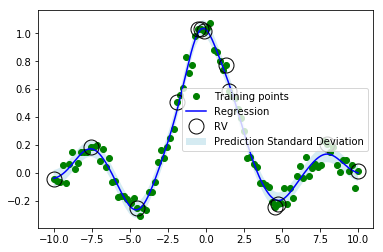

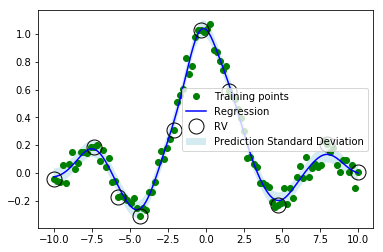

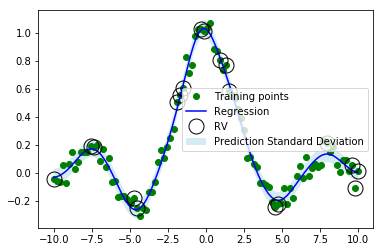

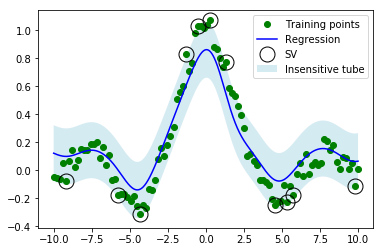

In [9]:
trainAndTest(X_tr, Y_tr, X_tst, Y_tst)